In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Change the directory to the Tables folder
TABLE_DIR = '/content/drive/MyDrive/LLM causality/Tables/'
FIG_DIR = '/content/drive/MyDrive/LLM causality/Figures/old/'

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import seaborn as sns

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils_full.py','wb').write(src)

Saving utils_full.py to utils_full.py


49428

In [ ]:
src = list(files.upload().values())[0]
open('plot_illustrate_full.py','wb').write(src)

Saving plot_illustrate_full.py to plot_illustrate_full.py


9612

In [ ]:
from utils_full import *

In [ ]:
from plot_illustrate_full import *

# Open LLM leaderboard (new version)

In [ ]:
# Benchmarks included in the leaderboard
cols_to_transform_new = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']

# Base models that we will look at
frequent_base_models_new = ['llama-3.1-8b', 'llama-3-8b', 'qwen2.5-14b',  'qwen2.5-7b',  'qwen2.5-0.5b', 'mistral-7b', 'gemma-2-9b']
base_model_dict_new = {'llama-3': 15., 'qwen2': 7., 'qwen2.5': 18., 'mistral-7b': 0.8, 'gemma-2-9b': 9. }

In [ ]:
df_new = pd.read_csv(TABLE_DIR + 'open_llm_leaderboard_with_tokens.csv')

In [ ]:
%%capture
plot_explained_variance(df_new, cols_to_transform_new)
plot_pca_distance(df_new, cols_to_transform_new)

In [ ]:
# Count the occurrences of each unique value in 'Identified base model'
model_counts = df_new['Identified base model'].value_counts()

# Display the most frequent entries
print(model_counts.head(10))  # Show the top 10 most frequent models

Identified base model
mistral-7b      2084
llama-2-13b      511
llama-3-8b       386
llama-2-7b       364
llama-2-70b      159
mixtral-8x7b     120
gemma-1-7b        58
llama-3-70b       56
llama-1-1.1b      41
gemma-2-2b        41
mixtral-7b        41
phi-1.5-2b        40
llama-1-3b        37
phi-2-2b          36
llama-3-3b        28
phi-2             26
qwen1-7b          25
gemma-1-2b        20
Name: count, dtype: int64


In [ ]:
frequent_base_models_dict_new = {}
# Find numbers appearing at least 50 times in 'Pretraining compute'

for model_name in frequent_base_models_new:
  # Find rows where 'fullname' contains the model_name
  matching_rows = df_new[df_new['Identified base model'].str.lower().str.contains(model_name, na=False)]
  print(f'{model_name} appears {len(matching_rows)} times')

  # Check if any matching rows were found
  if not matching_rows.empty:
    # If rows were found, select the first row
    matching_row = matching_rows.iloc[0]

    # Store the 'Pretraining compute' value in the dictionary
    frequent_base_models_dict_new[model_name] = matching_row['Pretraining tokens (T)']
  else:
    # If no rows were found, print a message or handle the case accordingly
    print(f"No rows found for model name: {model_name}")

llama-3.1-8b appears 0 times
No rows found for model name: llama-3.1-8b
llama-3-8b appears 386 times
qwen2.5-14b appears 6 times
qwen2.5-7b appears 0 times
No rows found for model name: qwen2.5-7b
qwen2.5-0.5b appears 0 times
No rows found for model name: qwen2.5-0.5b
mistral-7b appears 2084 times
gemma-2-9b appears 0 times
No rows found for model name: gemma-2-9b


In [ ]:
import os
n_components = 3
FIG_NEW_DIR = FIG_DIR + str(n_components) + '/'
# FIG_NEW_DIR = FIG_DIR + 'old/' + str(n_components) + '/'
FIG_NEW_PCA_DIR = FIG_NEW_DIR + 'pca_summary/'
FIG_NEW_ICA_DIR = FIG_NEW_DIR + 'ica_summary/'
if not os.path.exists(FIG_NEW_DIR):
  os.makedirs(FIG_NEW_DIR)
if not os.path.exists(FIG_NEW_PCA_DIR):
  os.makedirs(FIG_NEW_PCA_DIR)
if not os.path.exists(FIG_NEW_ICA_DIR):
  os.makedirs(FIG_NEW_ICA_DIR)

In [ ]:
FIG_NEW_DIR

'/content/drive/MyDrive/LLM causality/Figures/old/3/'

In [ ]:
len(df_filtered_new)

1016

## Perform PCA and ICA on invididual environments

From now on, we will treat the data (leaderboard performance) of all models with a specific base model as one single environment. Therefore, the previously defined five base models induce five environments, each of which contains a few observational data.

In [ ]:
plt.rcParams['font.family'] = 'serif'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import FuncNorm
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.impute import KNNImputer
from scipy.optimize import minimize
import seaborn as sns
import copy
import itertools

def component_analysis_flex(sub_df_dict, cols_to_use, num_cols = 5, num_rows = 2, n_components = 3):

    # Dictionary to store the PCA basis (principal directions) for each model.
    pca_components = {}

    fig_pca, axes_pca = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6))

    # Flatten the axes array for easier iteration
    axes_pca = axes_pca.flatten()


    #This contains the transpose of the individual ICA mixing matrices
    unmixing_list = []


    pca_index = 0

    # Perform PCA for each frequent compute value
    for name, subset_df in sub_df_dict.items():
        # Extract data for the current compute value
        data = subset_df[cols_to_use].values

        # Apply PCA
        pca = PCA(n_components=n_components) # Initialize PCA with desired number of components
        pca_result = pca.fit_transform(data)

        # Get eigenvalues
        eigenvalues = pca.explained_variance_

        # pca.components_ is shape (n_components, n_features).
        # Transpose so that columns are the eigenvectors (basis for the subspace).
        pca_components[name] = pca.components_.T # shape: (n_features, n_components)


        ax = axes_pca[pca_index]  # Subplot for explained variance
        # subplot for the mixing matrix
        mixing_matrix = pca.components_.T

        abs_max = np.abs(mixing_matrix).max()
        norm = FuncNorm((np.abs, lambda x: x), vmin=0, vmax=abs_max)
        ax.imshow(mixing_matrix, cmap='Greens', norm = norm, aspect = 'auto')
        ax.set_xticks([])
        ax.set_yticks(np.arange(mixing_matrix.shape[0]), cols_to_use)
        ax.set_ylabel('Original Feature')
        ax.set_title(f'PCA Mixing Matrix for \n {name}', fontsize=12)
        fig_pca.colorbar(ax.images[0], ax=ax)

        for j in range(mixing_matrix.shape[0]):
            for k in range(mixing_matrix.shape[1]):
                text = ax.text(k, j, f"{mixing_matrix[j, k]:.2f}",
                              ha="center", va="center", color="w", fontsize = 10)

        ax = axes_pca[pca_index + len(sub_df_dict)]  # Subplot for eigenvalues
        ax.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
        ax.set_title(f'Leading Eigenvalues for \n {name}', fontsize=12)
        ax.set_xlabel('Principal Component')
        ax.set_ylabel('Eigenvalue')
        ax.set_yscale('log')
        ax.grid(True)

        pca_index += 1

    fig_pca.tight_layout()

    '''
    Now we compute a cosine-similarity matrix between different PCA subspaces.
    '''

    fig_pca_sim, ax_pca_sim = plt.subplots(figsize=(8, 6))

    # List of model names
    models = list(pca_components.keys())
    num_models = len(models)

    # Initialize a similarity matrix.
    similarity_matrix = np.zeros((num_models, num_models))

    # Compute cosine distance between subspaces for each pair of models.
    for i in range(num_models):
        for j in range(num_models):
            U = pca_components[models[i]]  # Basis for model i
            V = pca_components[models[j]]  # Basis for model j

            # Compute the matrix of dot products: shape (n_components, n_components)
            M = np.dot(U.T, V)
            # Compute singular values; these are the cosines of the principal angles.
            singular_vals = np.linalg.svd(M, compute_uv=False)
            # Average cosine similarity across the principal angles.
            avg_cos_sim = np.mean(singular_vals)
            # Cosine distance defined as 1 minus the average cosine similarity.
            cosine_distance = 1 - avg_cos_sim
            similarity_matrix[i, j] = cosine_distance

    # Plot the similarity matrix as a heatmap.
    im_pca_sim = ax_pca_sim.imshow(similarity_matrix, cmap='Blues', aspect = 'auto')

    for j in range(similarity_matrix.shape[0]):
            for k in range(similarity_matrix.shape[1]):
                text = ax_pca_sim.text(k, j, f"{similarity_matrix[j, k]:.2f}",
                              ha="center", va="center", color="w", fontsize = 15)

    ax_pca_sim.set_xticks(np.arange(num_models))
    ax_pca_sim.set_yticks(np.arange(num_models))
    ax_pca_sim.set_xticklabels(models, fontsize=15, rotation=30, ha='right', va='top')
    ax_pca_sim.set_yticklabels(models, fontsize=15)
    fig_pca_sim.colorbar(im_pca_sim, ax=ax_pca_sim)
    # ax_pca_sim.set_title("Cosine Distance between PCA Subspaces")
    ax_pca_sim.grid(False)
    fig_pca_sim.tight_layout()

    return fig_pca, fig_pca_sim

In [ ]:
moe_dict = {"MoE models": df_new[df_new['MoE']==True], \
            "Mixtral": df_new[df_new['Architecture']=="MixtralForCausalLM"], \
            'non-MoE models': df_new[df_new['MoE']==False]}
fig_pca_moe, fig_pca_sim_moe = component_analysis_flex(moe_dict, cols_to_transform_new, num_cols = len(moe_dict), n_components=n_components)
fig_pca_moe.savefig(FIG_NEW_PCA_DIR + f'pca_plot_moe.pdf', dpi=300)
fig_pca_sim_moe.savefig(FIG_NEW_PCA_DIR + f'pca_similarity_moe.pdf', dpi=300)

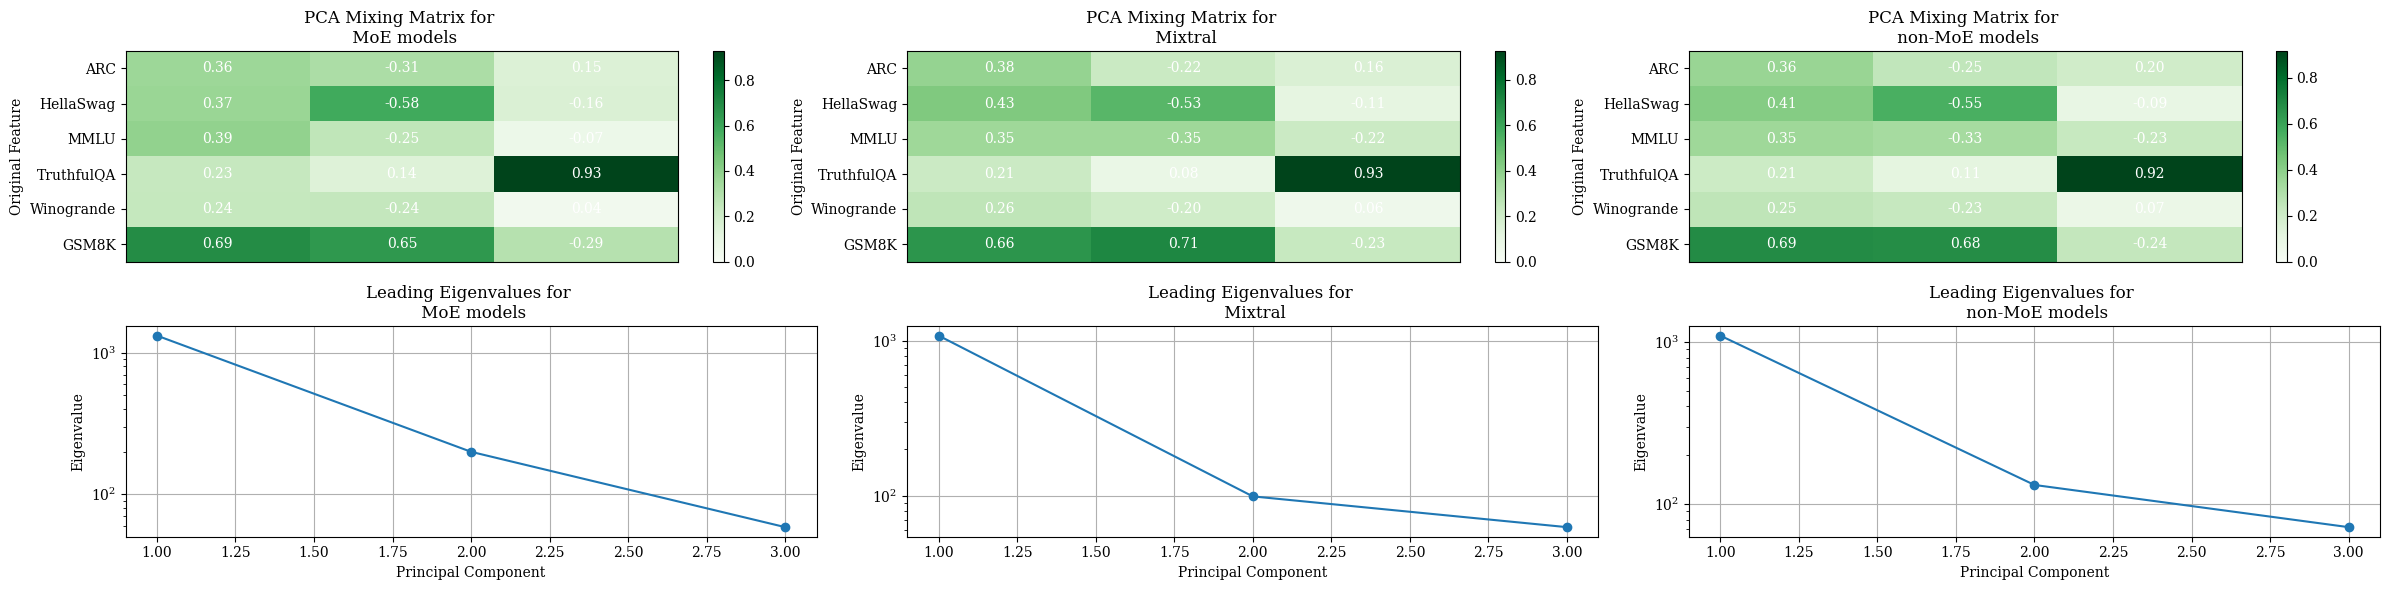

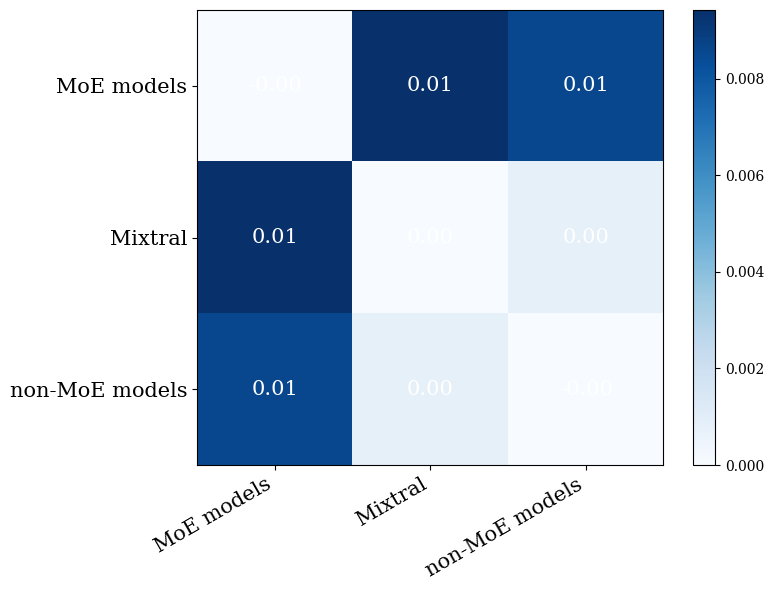

In [ ]:
moe_dict = {"MoE models": df_new[df_new['MoE']==True], \
            "Mixtral": df_new[df_new['Architecture']=="MixtralForCausalLM"], \
            'non-MoE models': df_new[df_new['MoE']==False]}
fig_pca_moe, fig_pca_sim_moe = component_analysis_flex(moe_dict, cols_to_transform_new, num_cols = len(moe_dict), n_components=n_components)
fig_pca_moe.savefig(FIG_NEW_PCA_DIR + f'pca_plot_moe.pdf', dpi=300)
fig_pca_sim_moe.savefig(FIG_NEW_PCA_DIR + f'pca_similarity_moe.pdf', dpi=300)

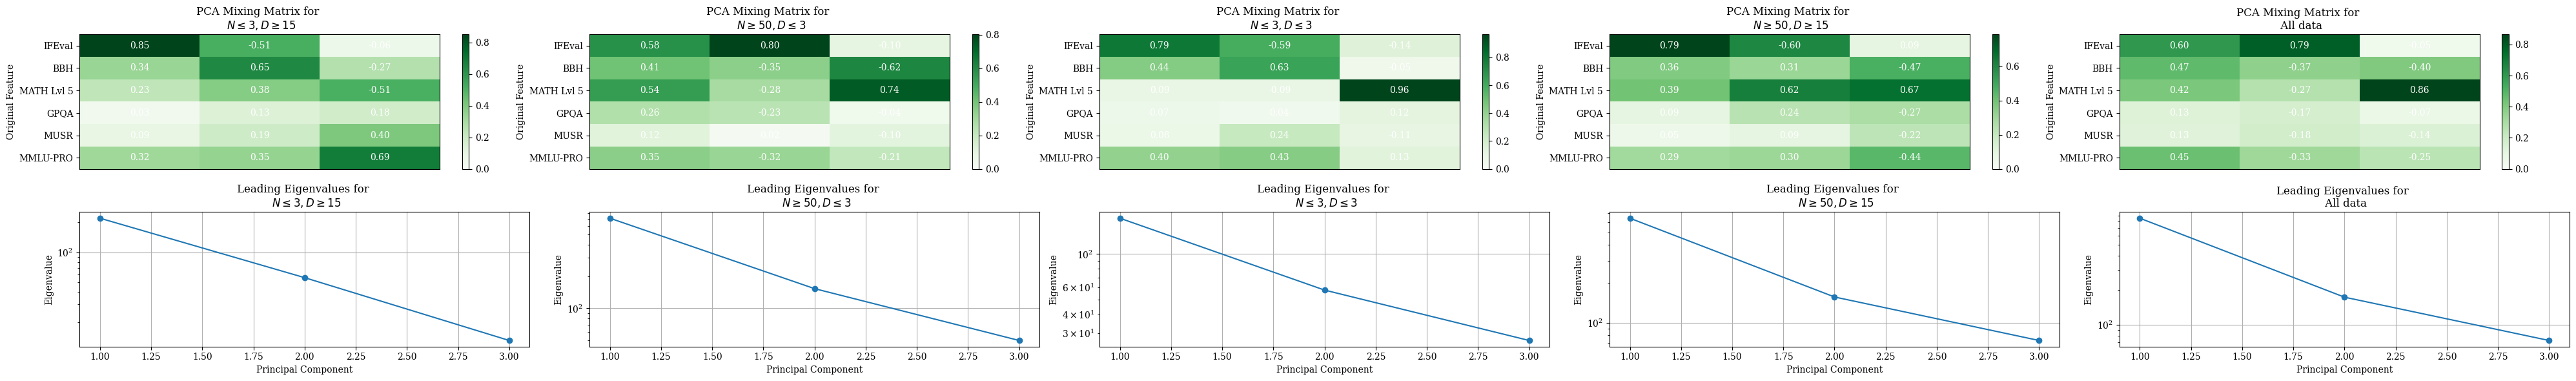

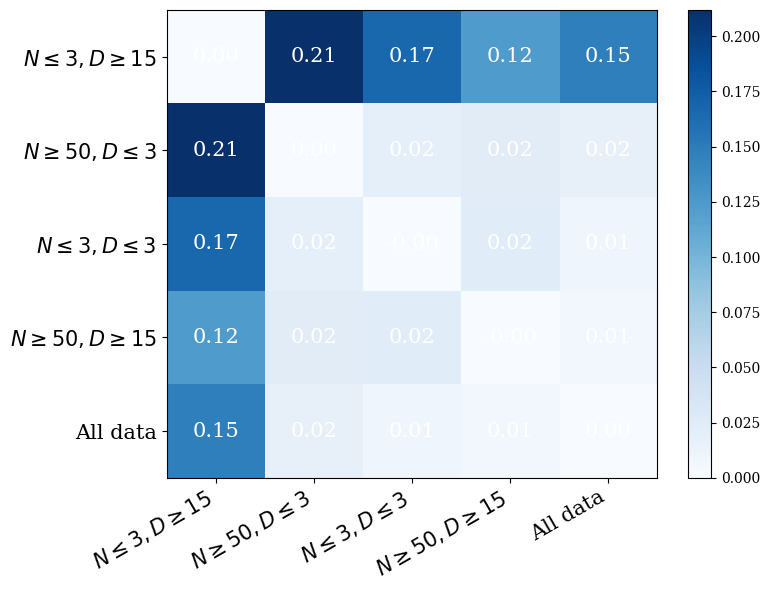

In [ ]:
chinchilla_dict = {r"$N \leq 3, D \geq 15$": df_new[(df_new["#Params (B)"] <= 3) & (df_new["Pretraining tokens (T)"] >= 15)], \
                   r"$N \geq 50, D \leq 3$": df_new[(df_new["#Params (B)"] >= 50) & (df_new["Pretraining tokens (T)"] <= 3)], \
                   r"$N \leq 3, D\leq 3$": df_new[(df_new["#Params (B)"] <= 3) & (df_new["Pretraining tokens (T)"] <= 3)], \
                   r"$N \geq 50, D \geq 15$": df_new[(df_new["#Params (B)"] >= 50) & (df_new["Pretraining tokens (T)"] >= 15)], \
                   "All data": df_new}

fig_pca_chinchilla, fig_pca_sim_chinchilla = component_analysis_flex(chinchilla_dict, cols_to_transform_new, num_cols = len(chinchilla_dict), n_components=n_components)
fig_pca_chinchilla.savefig(FIG_NEW_PCA_DIR + f'pca_plot_chinchilla.pdf', dpi=300)
fig_pca_sim_chinchilla.savefig(FIG_NEW_PCA_DIR + f'pca_similarity_chinchilla.pdf', dpi=300)

In [ ]:
# Filter the DataFrame based on the specified criteria
filtered_df = df_new[(df_new["#Params (B)"] <= 3) & (df_new["Pretraining tokens (T)"] >= 15)]

# Count the occurrences of each unique value in 'Identified base model' for the filtered data
model_counts = filtered_df['Identified base model'].value_counts()

# Get the two most frequent entries and their counts
top_two_models = model_counts.head(2)

# Print the results
top_two_models


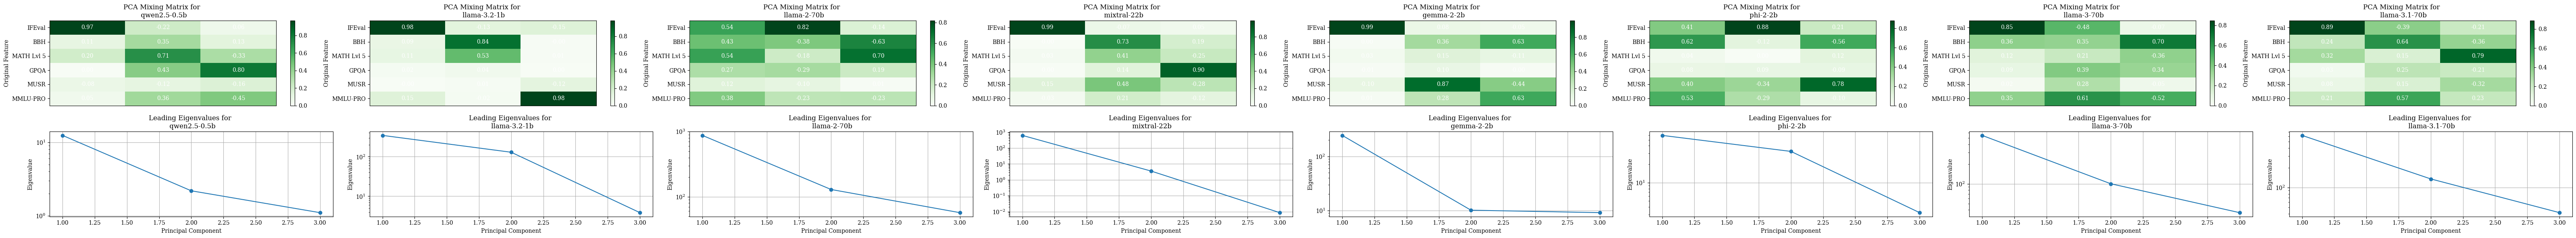

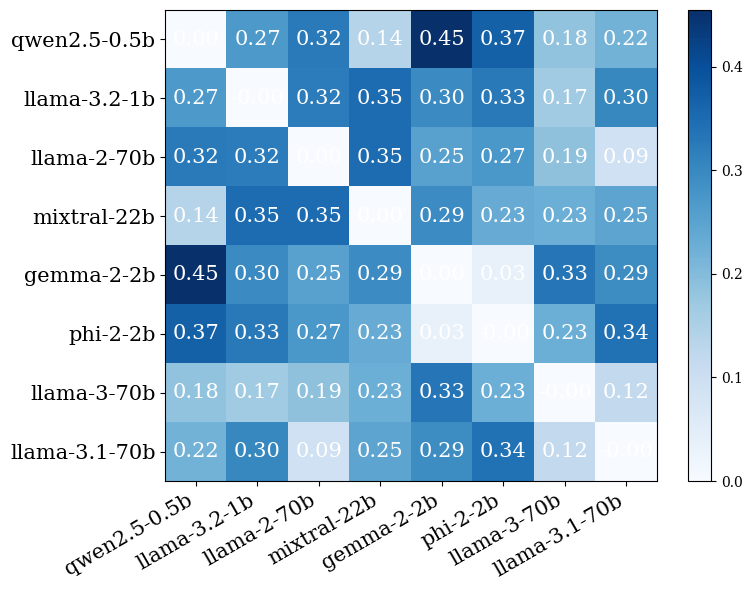

In [ ]:
base_specific_dict = {}

for key, values in list(chinchilla_dict.items())[:-1]:

  # Count the occurrences of each unique value in 'Identified base model'
  model_counts = values['Identified base model'].value_counts()
  top_two_models = model_counts.head(2).index.tolist()

  for model in top_two_models:
    base_specific_dict[model] = values[values['Identified base model'] == model]

fig_pca_base, fig_pca_sim_base = component_analysis_flex(base_specific_dict, cols_to_transform_new, num_cols = len(base_specific_dict), n_components=n_components)
fig_pca_base.savefig(FIG_NEW_PCA_DIR + f'pca_plot_chinchilla_base.pdf', dpi=300)
fig_pca_sim_base.savefig(FIG_NEW_PCA_DIR + f'pca_similarity_chinchilla_base.pdf', dpi=300)


In [ ]:
df_new["Type"].unique()

array(['💬 chat models (RLHF, DPO, IFT, ...)', '🟢 pretrained',
       '🔶 fine-tuned on domain-specific datasets',
       '🤝 base merges and moerges', '🟩 continuously pretrained',
       '🌸 multimodal', '❓ other'], dtype=object)

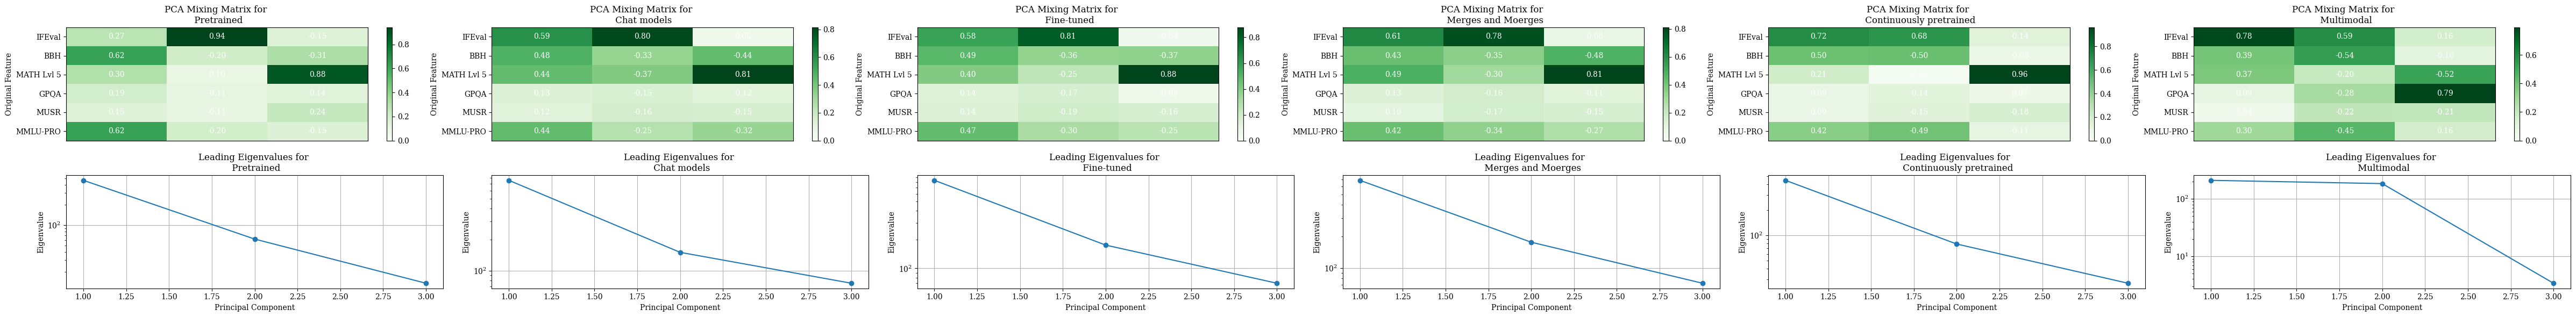

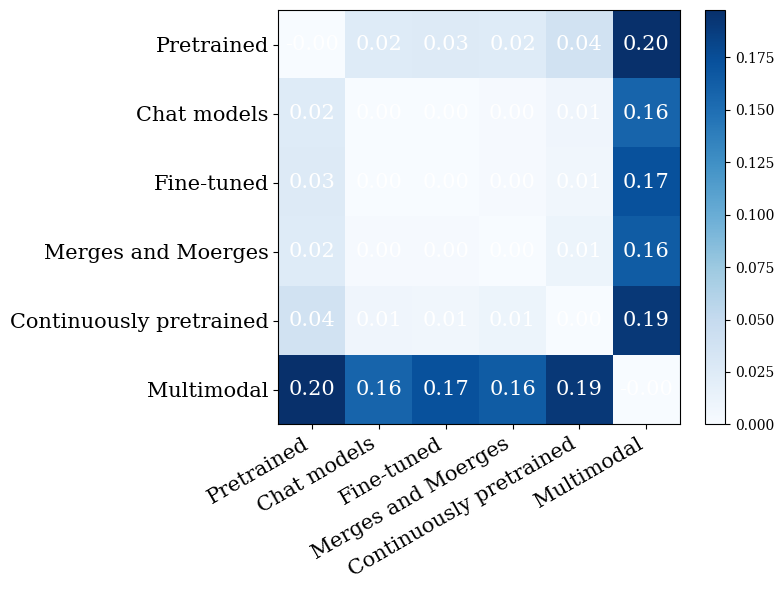

In [ ]:
model_type_dict = {"Pretrained": df_new[df_new["Type"]=='🟢 pretrained'], \
                   "Chat models": df_new[df_new["Type"]=='💬 chat models (RLHF, DPO, IFT, ...)'], \
                   "Fine-tuned": df_new[df_new["Type"]=='🔶 fine-tuned on domain-specific datasets'],\
                   "Merges and Moerges": df_new[df_new["Type"]=='🤝 base merges and moerges'],\
                   "Continuously pretrained": df_new[df_new["Type"]=='🟩 continuously pretrained'],\
                   "Multimodal": df_new[df_new["Type"]=='🌸 multimodal']}
fig_pca_type, fig_pca_sim_type = component_analysis_flex(model_type_dict, cols_to_transform_new, num_cols = len(model_type_dict), n_components=n_components)
fig_pca_type.savefig(FIG_NEW_PCA_DIR + f'pca_plot_type.pdf', dpi=300)
fig_pca_sim_type.savefig(FIG_NEW_PCA_DIR + f'pca_similarity_type.pdf', dpi=300)

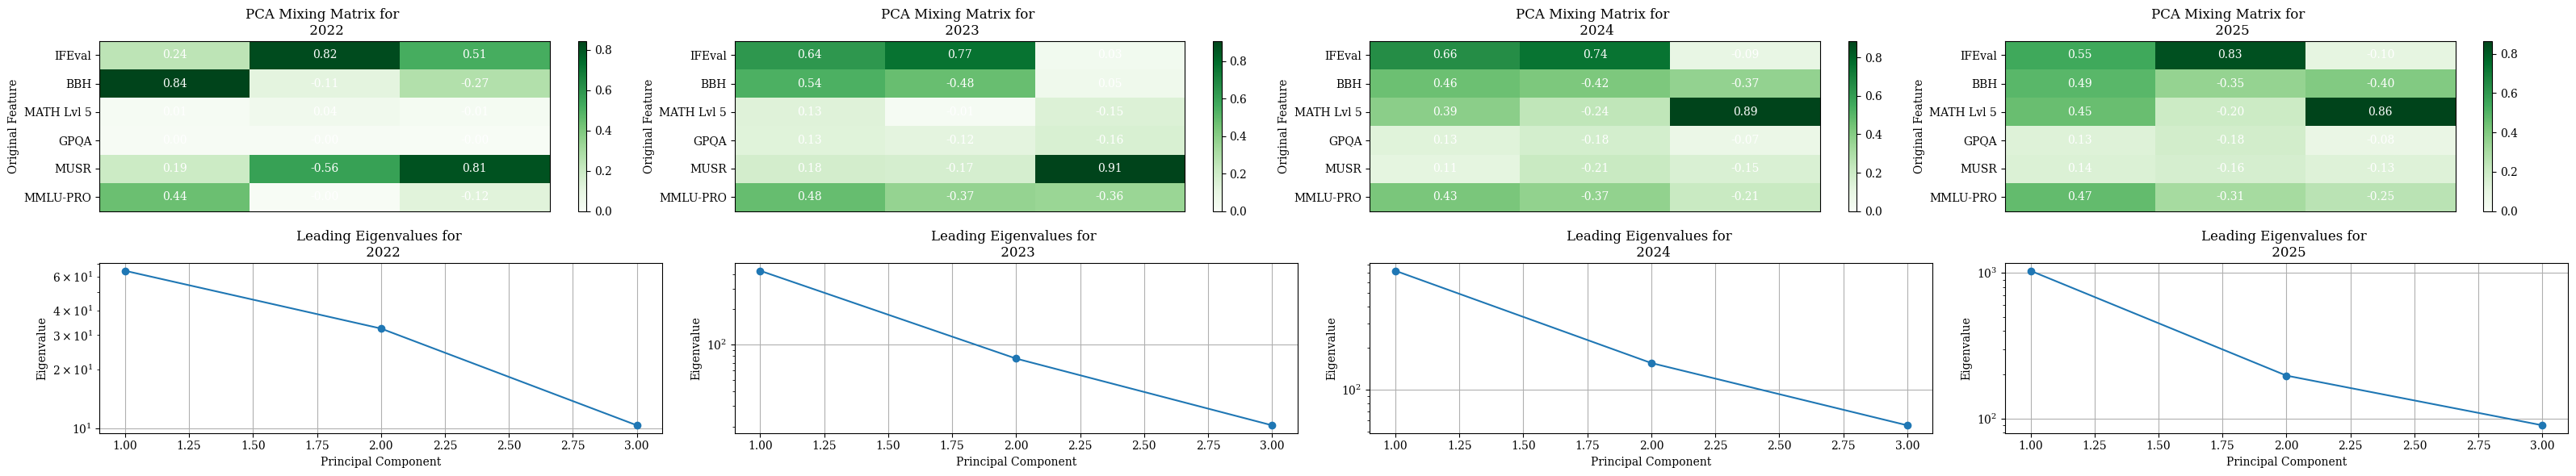

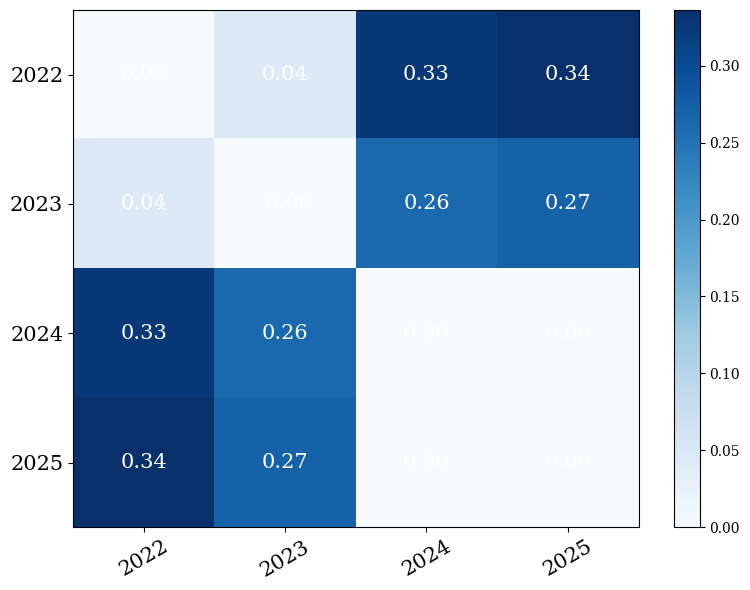

In [ ]:
# Assuming 'df_new' is your DataFrame and 'Upload To Hub Date' column exists.
# Also assuming 'Upload To Hub Date' column is of 'object' type and in 'yyyy-mm-dd' format.

year_dfs = {}
for year in range(2022, 2026):  # Iterate through years 2022 to 2025
    # Convert 'Upload To Hub Date' to datetime objects if not already done
    if not pd.api.types.is_datetime64_any_dtype(df_new['Upload To Hub Date']):
        df_new['Upload To Hub Date'] = pd.to_datetime(df_new['Upload To Hub Date'], errors='coerce')

    # Filter the DataFrame for the current year, handling potential NaT values
    year_dfs[str(year)] = df_new[df_new['Upload To Hub Date'].dt.year == year]

fig_pca_date, fig_pca_sim_date = component_analysis_flex(year_dfs, cols_to_transform_new, num_cols = len(year_dfs), n_components=n_components)
fig_pca_date.savefig(FIG_NEW_PCA_DIR + f'pca_plot_date.pdf', dpi=300)
fig_pca_sim_date.savefig(FIG_NEW_PCA_DIR + f'pca_similarity_date.pdf', dpi=300)